<a href="https://colab.research.google.com/github/bchiramani/Python/blob/main/LearningAboutFeatureScaling_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import math
from scipy.stats import norm


In [5]:
df = pd.read_csv('/content/HousePricesTrain.csv')
df.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Data Definition


* LotArea: Lot size in square feet
* Street: Type of road access to property
* LotShape: General shape of property
* YearBuilt: Original construction date
* TotalBsmtSF: Total square feet of basement area
* 1stFlrSF: First Floor square feet
* 2ndFlrSF: Second floor square feet
* BedroomAbvGr: Bedrooms above grade (does NOT include basement bedrooms)
* PoolArea: Pool area in square feet













In [6]:
df = df[['Id','LotArea','Street','LotShape','YearBuilt','TotalBsmtSF','1stFlrSF','2ndFlrSF','BedroomAbvGr','PoolArea','SalePrice']]
df.head()



,Id,LotArea,Street,LotShape,YearBuilt,TotalBsmtSF,1stFlrSF,2ndFlrSF,BedroomAbvGr,PoolArea,SalePrice
0,1,8450,Pave,Reg,2003,856,856,854,3,0,208500
1,2,9600,Pave,Reg,1976,1262,1262,0,3,0,181500
2,3,11250,Pave,IR1,2001,920,920,866,3,0,223500
3,4,9550,Pave,IR1,1915,756,961,756,3,0,140000
4,5,14260,Pave,IR1,2000,1145,1145,1053,4,0,250000


# Data Cleaning

In [7]:
# dropping column Id from dataframe
df.drop('Id',axis=1,inplace=True)
def check_null_percentage(df):
    missing_info = pd.DataFrame(np.array(df.isnull().sum().sort_values(ascending=False).reset_index())\
                                ,columns=['Columns','Missing_Percentage']).query("Missing_Percentage > 0").set_index('Columns')
    return 100*missing_info/df.shape[0]

In [8]:
check_null_percentage(df)


,Missing_Percentage
Columns,


In [9]:
df[df.isnull().sum(axis=1) > 5]

,LotArea,Street,LotShape,YearBuilt,TotalBsmtSF,1stFlrSF,2ndFlrSF,BedroomAbvGr,PoolArea,SalePrice


# Choosing Features



In [41]:
X_train=df[['LotArea','TotalBsmtSF','BedroomAbvGr','PoolArea']]
y_train=df['SalePrice']
X_features=['LotArea','TotalBsmtSF','BedroomAbvGr','PoolArea']
X_train=X_train.values

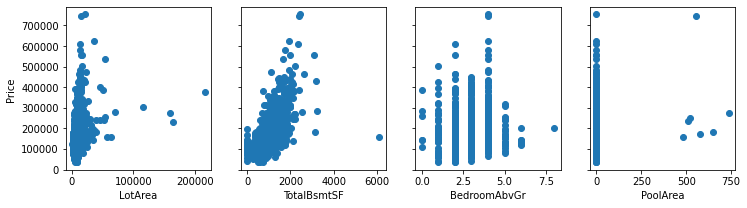

In [43]:
fig,ax=plt.subplots(1, 4, figsize=(12, 3), sharey=True)

for i in range(len(ax)):
    ax[i].scatter(X_train[:,i],y_train)
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("Price ")
plt.show()

Plotting the price depending on each feature provides some indication of which features have the strongest influence on price. 

# Gradient Descent With Multiple Variables
Here are the equations you developed in the last lab on gradient descent for multiple variables.:

$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline\;
& w_j := w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{1}  \; & \text{for j = 0..n-1}\newline
&b\ \ := b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b}  \newline \rbrace
\end{align*}$$





In [47]:
def compute_cost(X, y, w, b): 
    """
    compute cost
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      cost (scalar): cost
    """
    m = X.shape[0]
    cost = 0.0
    for i in range(m):                                
        f_wb_i = np.dot(X[i], w) + b           #(n,)(n,) = scalar (see np.dot)
        cost = cost + (f_wb_i - y[i])**2       #scalar
    cost = cost / (2 * m)                      #scalar    
    return cost

In [53]:
def compute_gradient_matrix(X, y, w, b):
    """
    Computes the gradient for linear regression

    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
    Returns
      dj_dw (ndarray (n,1)): The gradient of the cost w.r.t. the parameters w.
      dj_db (scalar):        The gradient of the cost w.r.t. the parameter b.

    """
    m,n = X.shape
    f_wb = X @ w + b
    e   = f_wb - y
    dj_dw  = (1/m) * (X.T @ e)
    dj_db  = (1/m) * np.sum(e)

    return dj_db,dj_dw

In [58]:
def gradient_descent_houses(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X : (array_like Shape (m,n)    matrix of examples 
      y : (array_like Shape (m,))    target value of each example
      w_in : (array_like Shape (n,)) Initial values of parameters of the model
      b_in : (scalar)                Initial value of parameter of the model
      cost_function: function to compute cost
      gradient_function: function to compute the gradient
      alpha : (float) Learning rate
      num_iters : (int) number of iterations to run gradient descent
    Returns
      w : (array_like Shape (n,)) Updated values of parameters of the model after
          running gradient descent
      b : (scalar)                Updated value of parameter of the model after
          running gradient descent
    """
    
    # number of training examples
    m = len(X)
    
    # An array to store values at each iteration primarily for graphing later
    hist={}
    hist["cost"] = []; hist["params"] = []; hist["grads"]=[]; hist["iter"]=[];
    
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    save_interval = np.ceil(num_iters/10000) # prevent resource exhaustion for long runs

    print(f"Iteration Cost          w0       w1       w2       w3       b       djdw0    djdw1    djdw2    djdw3    djdb  ")
    print(f"---------------------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|")

    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db,dj_dw = gradient_function(X, y, w, b)   

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               
        b = b - alpha * dj_db               
      
        # Save cost J,w,b at each save interval for graphing
        if i == 0 or i % save_interval == 0:     
            hist["cost"].append(cost_function(X, y, w, b))
            hist["params"].append([w,b])
            hist["grads"].append([dj_dw,dj_db])
            hist["iter"].append(i)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0:
            #print(f"Iteration {i:4d}: Cost {cost_function(X, y, w, b):8.2f}   ")
            cst = cost_function(X, y, w, b)
            print(f"{i:9d} {cst:0.5e} {w[0]: 0.1e} {w[1]: 0.1e} {w[2]: 0.1e} {w[3]: 0.1e} {b: 0.1e} {dj_dw[0]: 0.1e} {dj_dw[1]: 0.1e} {dj_dw[2]: 0.1e} {dj_dw[3]: 0.1e} {dj_db: 0.1e}")
       
    return w, b, hist #return w,b and history for graphing

In [105]:
def run_gradient_descent(X,y,iterations=100000, alpha = 1e-6):

    m,n = X.shape
    # initialize parameters
    initial_w = np.zeros(n)
    initial_b = 0
    # run gradient descent
    w_out, b_out, hist_out = gradient_descent_houses(X ,y, initial_w, initial_b,
                                               compute_cost, compute_gradient_matrix, alpha, iterations)
    print(f"w,b found by gradient descent: w: {w_out}, b: {b_out:0.2f}")
    
    return(w_out, b_out, hist_out)

In [106]:
def plot_cost_i_w(X,y,hist):
    ws = np.array([ p[0] for p in hist["params"]])
    rng = max(abs(ws[:,0].min()),abs(ws[:,0].max()))
    wr = np.linspace(-rng+0.27,rng+0.27,20)
    cst = [compute_cost(X,y,np.array([wr[i],-32, -67, -1.46]), 221) for i in range(len(wr))]

    fig,ax = plt.subplots(1,2,figsize=(12,3))
    ax[0].plot(hist["iter"], (hist["cost"]));  ax[0].set_title("Cost vs Iteration")
    ax[0].set_xlabel("iteration"); ax[0].set_ylabel("Cost")
    ax[1].plot(wr, cst); ax[1].set_title("Cost vs w[0]")
    ax[1].set_xlabel("w[0]"); ax[1].set_ylabel("Cost")
    ax[1].plot(ws[:,0],hist["cost"])
    plt.show()

#  Learning rate


In [107]:
_, _, hist = run_gradient_descent(X_train, y_train, 10, alpha = 1e-8)

Iteration Cost          w0       w1       w2       w3       b       djdw0    djdw1    djdw2    djdw3    djdb  
---------------------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
        0 2.18867e+10  2.1e+01  2.1e+00  5.3e-03  7.9e-03  1.8e-03 -2.1e+09 -2.1e+08 -5.3e+05 -7.9e+05 -1.8e+05
        1 2.48159e+10 -2.4e+00  1.6e+00  4.0e-03  3.1e-03  1.4e-03  2.4e+09  4.9e+07  1.3e+05  4.9e+05  4.3e+04
        2 2.84359e+10  2.4e+01  4.0e+00  9.9e-03  1.2e-02  3.4e-03 -2.6e+09 -2.4e+08 -6.0e+05 -9.3e+05 -2.0e+05
        3 3.29049e+10 -5.3e+00  3.2e+00  7.8e-03  5.9e-03  2.7e-03  2.9e+09  8.2e+07  2.2e+05  6.4e+05  7.1e+04
        4 3.84175e+10  2.7e+01  6.0e+00  1.5e-02  1.7e-02  5.0e-03 -3.2e+09 -2.7e+08 -6.9e+05 -1.1e+06 -2.3e+05
        5 4.52128e+10 -8.9e+00  4.7e+00  1.1e-02  8.5e-03  4.0e-03  3.6e+09  1.2e+08  3.2e+05  8.4e+05  1.1e+05
        6 5.35850e+10  3.0e+01  7.9e+00  1.9e-02  2.2e-02  6.7e-03 -3.9e+09 -3.2e+08 -7.9e+05 -1.3e+06 -

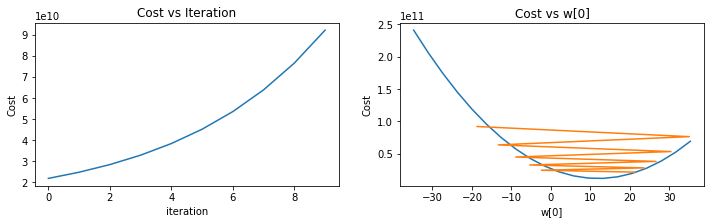

In [108]:
plot_cost_i_w(X_train, y_train, hist)

In [113]:
_, _, hist = run_gradient_descent(X_train, y_train, 10, alpha = 2e-9)

Iteration Cost          w0       w1       w2       w3       b       djdw0    djdw1    djdw2    djdw3    djdb  
---------------------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
        0 1.24065e+10  4.2e+00  4.3e-01  1.1e-03  1.6e-03  3.6e-04 -2.1e+09 -2.1e+08 -5.3e+05 -7.9e+05 -1.8e+05
        1 1.00177e+10  6.7e+00  7.5e-01  1.9e-03  2.7e-03  6.3e-04 -1.2e+09 -1.6e+08 -4.0e+05 -5.4e+05 -1.4e+05
        2 9.20844e+09  8.1e+00  1.0e+00  2.5e-03  3.4e-03  8.5e-04 -7.0e+08 -1.3e+08 -3.2e+05 -3.9e+05 -1.1e+05
        3 8.92742e+09  8.9e+00  1.2e+00  3.0e-03  4.0e-03  1.0e-03 -4.0e+08 -1.1e+08 -2.8e+05 -3.0e+05 -9.5e+04
        4 8.82304e+09  9.3e+00  1.4e+00  3.5e-03  4.6e-03  1.2e-03 -2.3e+08 -1.0e+08 -2.5e+05 -2.5e+05 -8.6e+04
        5 8.77775e+09  9.6e+00  1.6e+00  4.0e-03  5.0e-03  1.4e-03 -1.3e+08 -9.6e+07 -2.3e+05 -2.2e+05 -8.1e+04
        6 8.75223e+09  9.7e+00  1.8e+00  4.5e-03  5.4e-03  1.5e-03 -7.4e+07 -9.3e+07 -2.3e+05 -2.1e+05 -

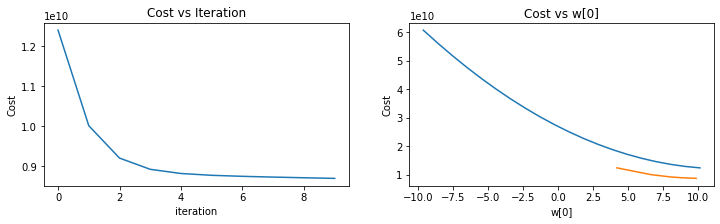

In [114]:
plot_cost_i_w(X_train, y_train, hist)

On the left, you see that cost is decreasing as it should. On the right you can see that  𝑤0  is decreasing without crossing the minimum

# Feature Scaling
* Mean normalization: $x_i := \dfrac{x_i - \mu_i}{max - min} $ 
* Z-score normalization :  $$x^{(i)}_j = \dfrac{x^{(i)}_j - \mu_j}{\sigma_j} \tag{4}$$

In [115]:
def zscore_normalize_features(X):
    """
    computes  X, zcore normalized by column
    
    Args:
      X (ndarray (m,n))     : input data, m examples, n features
      
    Returns:
      X_norm (ndarray (m,n)): input normalized by column
      mu (ndarray (n,))     : mean of each feature
      sigma (ndarray (n,))  : standard deviation of each feature
    """
    # find the mean of each column/feature
    mu     = np.mean(X, axis=0)                 # mu will have shape (n,)
    # find the standard deviation of each column/feature
    sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - mu) / sigma      

    return (X_norm, mu, sigma)

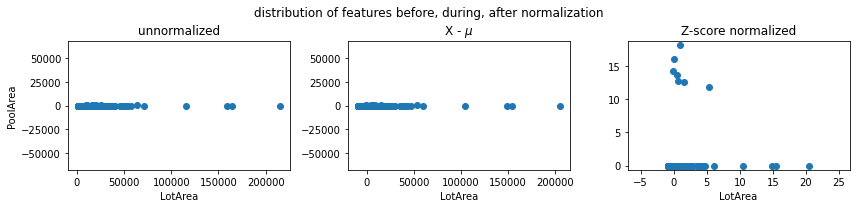

In [116]:
mu     = np.mean(X_train,axis=0)   
sigma  = np.std(X_train,axis=0) 
X_mean = (X_train - mu)
X_norm = (X_train - mu)/sigma      

fig,ax=plt.subplots(1, 3, figsize=(12, 3))
ax[0].scatter(X_train[:,0], X_train[:,3])
ax[0].set_xlabel(X_features[0]); ax[0].set_ylabel(X_features[3]);
ax[0].set_title("unnormalized")
ax[0].axis('equal')

ax[1].scatter(X_mean[:,0], X_mean[:,3])
ax[1].set_xlabel(X_features[0]); ax[0].set_ylabel(X_features[3]);
ax[1].set_title(r"X - $\mu$")
ax[1].axis('equal')

ax[2].scatter(X_norm[:,0], X_norm[:,3])
ax[2].set_xlabel(X_features[0]); ax[0].set_ylabel(X_features[3]);
ax[2].set_title(r"Z-score normalized")
ax[2].axis('equal')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("distribution of features before, during, after normalization")
plt.show()

Let's normalize the data and compare it to the original data.


In [117]:
# normalize the original features
X_norm, X_mu, X_sigma = zscore_normalize_features(X_train)
print(f"X_mu = {X_mu}, \nX_sigma = {X_sigma}")
print(f"Peak to Peak range by column in Raw        X:{np.ptp(X_train,axis=0)}")   
print(f"Peak to Peak range by column in Normalized X:{np.ptp(X_norm,axis=0)}")

X_mu = [1.05168281e+04 1.05742945e+03 2.86643836e+00 2.75890411e+00], 
X_sigma = [9.97784611e+03 4.38555057e+02 8.15498620e-01 4.01635452e+01]
Peak to Peak range by column in Raw        X:[213945   6110      8    738]
Peak to Peak range by column in Normalized X:[21.44200239 13.93211616  9.80994915 18.37487193]


In [121]:
def norm_plot(ax, data):
    scale = (np.max(data) - np.min(data))*0.2
    x = np.linspace(np.min(data)-scale,np.max(data)+scale,50)
    _,bins, _ = ax.hist(data, x, color="xkcd:azure")
    #ax.set_ylabel("Count")
    
    mu = np.mean(data); 
    std = np.std(data); 
    dist = norm.pdf(bins, loc=mu, scale = std)
    
    axr = ax.twinx()
    axr.plot(bins,dist, color = "orangered", lw=2)
    axr.set_ylim(bottom=0)
    axr.axis('off')

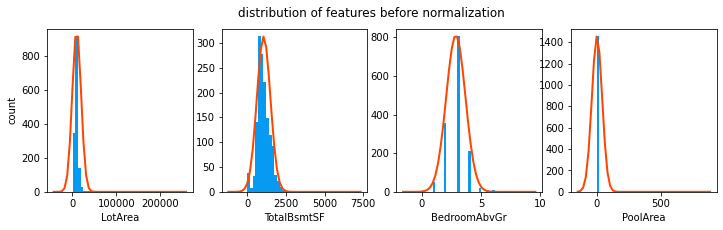

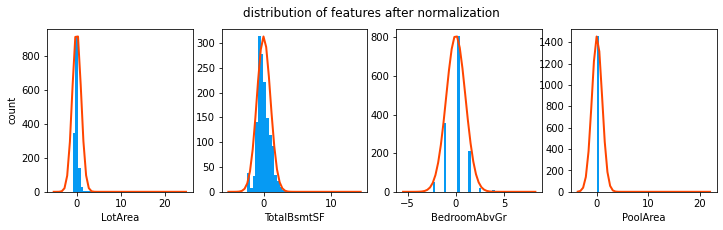

In [122]:
fig,ax=plt.subplots(1, 4, figsize=(12, 3))
for i in range(len(ax)):
    norm_plot(ax[i],X_train[:,i],)
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("count");
fig.suptitle("distribution of features before normalization")
plt.show()
fig,ax=plt.subplots(1,4,figsize=(12,3))
for i in range(len(ax)):
    norm_plot(ax[i],X_norm[:,i],)
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("count"); 
fig.suptitle("distribution of features after normalization")

plt.show()

Notice, above, the range of the normalized data (x-axis) is centered around zero Most importantly, the range is similar for each feature.